In [78]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append ('../../')

In [79]:
from fastai.conv_learner import *

In [80]:
path = Path("../../storage/cifar10")
os.makedirs(path, exist_ok=True)
torch.cuda.set_device(0)

In [81]:
bs = 256
sz = 32

In [93]:
train_dataset = torchvision.datasets.ImageFolder(root=path,
    transform=torchvision.transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=60000
)

train = next(iter(train_loader))[0]
mean = np.array(np.mean(train.numpy(), axis=(0, 2, 3)))
std = np.array(np.std(train.numpy(), axis=(0, 2, 3)))

In [82]:
print(std)

[0.24697 0.24339 0.26159]


In [94]:
tfms = tfms_from_stats((mean, std), sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(path, val_name='test', tfms=tfms, bs=bs)

In [118]:
def conv_layer(ch_in, ch_out, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(ch_out, momentum=0.01),
        nn.LeakyReLU(0.1)
    )

class ResLayer(nn.Module):
    def __init__(self, ch_in):
        super().__init__()
        self.res_layer = nn.Sequential(
            conv_layer(ch_in, ch_in // 2, ks=1),
            conv_layer(ch_in // 2, ch_in, ks=3)
        )
    
    def forward(self, x): return x.add_(self.res_layer(x))

class Darknet(nn.Module):
    def group_layer(self,ch_in, n_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2, stride=stride) 
               ] + [(ResLayer(ch_in*2)) for i in range(n_blocks)]
    
    def __init__(self, n_blocks, n_classes, start_filters=32):
        super().__init__()
        cf = start_filters # Current no of filters
        layers = [conv_layer(3, cf)]
        for idx, n in enumerate(n_blocks):
            layers += self.group_layer(cf, n, stride=2-(idx==1))
            cf *= 2        
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(cf, n_classes)]o
        self.layers = nn.Sequential(*layers)
        
    
    def forward(self, x): return self.layers(x)

In [119]:
model = Darknet([1, 2, 4, 6, 3], n_classes=10, start_filters=32)

In [120]:
lr = 1.3
learn = ConvLearner.from_model_data(model, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
weight_decay =1e-4

In [121]:
#learn.load("dark")
%time learn.fit(lr, 1, wds=weight_decay, cycle_len=2, use_clr_beta=(20, 20, 0.95, 0.85))
learn.save("dark")

epoch      trn_loss   val_loss   accuracy   
    0      2.450597   2.759572   0.1       
    1      1.92561    2.046956   0.1999    
CPU times: user 9min 1s, sys: 7min 16s, total: 16min 17s
Wall time: 15min 40s


In [122]:
%time learn.fit(lr, 1, wds=weight_decay, cycle_len=10, use_clr_beta=(20, 20, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy   
    0      1.837295   2.020283   0.2396    
    1      1.73976    1.790392   0.3185    
    2      1.573827   1.774054   0.3276    
    3      1.422546   1.739194   0.3353    
    4      1.224477   1.647923   0.4596    
    5      1.073003   1.381992   0.5149    
    6      0.929145   1.46368    0.4994    
    7      0.769597   0.943564   0.6712    
    8      0.660627   0.750242   0.7363    
    9      0.596186   0.599294   0.791     
CPU times: user 39min 10s, sys: 31min 36s, total: 1h 10min 46s
Wall time: 1h 6min 23s


[array([0.59929]), 0.791]

In [125]:
learn.lr_find()

 99%|█████████▉| 195/196 [06:45<00:02,  2.08s/it, loss=5.52]

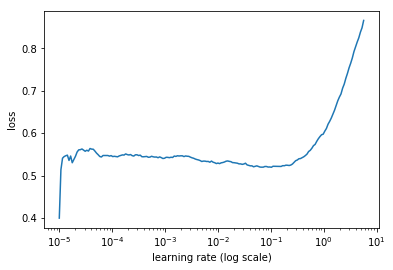

In [126]:
learn.sched.plot(0)

In [127]:
%time learn.fit(5e-2, 1, wds=weight_decay, cycle_len=10, use_clr_beta=(10, 15, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy   
    0      0.499986   0.52831    0.8167    
    1      0.482231   0.56194    0.8065    
    2      0.473561   0.518422   0.8203    
    4      0.451952   0.517726   0.8227    
    5      0.438909   0.509657   0.824     
    6      0.412962   0.472713   0.8345    
    7      0.38984    0.508526   0.824     
    8      0.366794   0.448364   0.8445    
    9      0.354355   0.434575   0.8511    
CPU times: user 39min 15s, sys: 31min 29s, total: 1h 10min 44s
Wall time: 1h 6min 21s


[array([0.43458]), 0.8511]